In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
cardio_data = pd.read_csv('data/cardio_data.csv', sep = ';')
cardio_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [17]:
# changing column names
cardio_data.rename(columns = {'ap_hi': 'blood_pressure_max', 'ap_lo': 'blood_pressure_min', 'cholesterol': 'cholesterol_level', 'gluc': 'glucose_level', 'smoke': 'smoking_status', 'alco': 'alcohol_status', 'active': 'activity_level', 'cardio': 'disease'}, inplace = True)
# casting datatypes
cardio_data['height'] = cardio_data['height'].astype('float')
# converting age from days to years
cardio_data['age'] = cardio_data['age'] // 365
# converting gender into a binary variable
cardio_data['gender'] = cardio_data['gender'] - 1
# calculating bmi
cardio_data['bmi'] = cardio_data['weight'] / (cardio_data['height'] / 100)**2
# dropping height and weight columns
cardio_data.drop(columns = ['height', 'weight'], inplace = True)

In [18]:
# changing sign of negative blood pressure values
cardio_data['blood_pressure_min'] = cardio_data['blood_pressure_min'].map(lambda x: -1 * x if x < 0 else x)
cardio_data['blood_pressure_max'] = cardio_data['blood_pressure_max'].map(lambda x: -1 * x if x < 0 else x)
# calculating blood pressure difference
cardio_data['blood_pressure_diff'] = cardio_data['blood_pressure_max'] - cardio_data['blood_pressure_min']
# dropping rows with diastolic blood pressure > systolic blood pressure
cardio_data = cardio_data.loc[cardio_data['blood_pressure_diff'] > 0]
# dropping rows with unreasonable bmi values
cardio_data = cardio_data.loc[(cardio_data['bmi'] > 10) & (cardio_data['bmi'] < 60)]
# dropping rows with unreasonable blood pressure values
cardio_data = cardio_data.loc[(cardio_data['blood_pressure_max'] > 70) & (cardio_data['blood_pressure_max'] < 200)]
cardio_data = cardio_data.loc[(cardio_data['blood_pressure_min'] > 40) & (cardio_data['blood_pressure_min'] < 160)]
# dropping duplicate values
cardio_data.drop_duplicates(inplace = True)
# dropping id column
cardio_data.drop(columns = ['id'], inplace = True)

In [19]:
cardio_data.to_csv('data/cardio_data_clean.csv')

In [20]:
cardio_data = pd.read_csv('data/cardio_data_clean.csv').drop(columns = ['Unnamed: 0'])
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,bmi,blood_pressure_diff
0,50,1,110,80,1,1,0,0,1,0,21.967120,30
1,55,0,140,90,3,1,0,0,1,1,34.927679,50
2,51,0,130,70,3,1,0,0,0,1,23.507805,60
3,48,1,150,100,1,1,0,0,1,1,28.710479,50
4,47,0,100,60,1,1,0,0,0,0,23.011177,40


In [21]:
cardio_data['disease'].value_counts(normalize = True).round(3)
# very marginal class imbalance -> downsample minority class

0    0.506
1    0.494
Name: disease, dtype: float64

In [22]:
# downsampling minority class
no_disease = cardio_data.loc[cardio_data['disease'] == 0]
disease = cardio_data.loc[cardio_data['disease'] == 1]
no_disease_reduced = no_disease.sample(n = len(disease), random_state = 0)
cardio_data = pd.concat([disease, no_disease_reduced], axis = 0)

In [9]:
cardio_data.groupby('gender')['disease'].mean().round(3)

gender
0    0.498
1    0.505
Name: disease, dtype: float64

In [6]:
cardio_data.groupby('alcohol_status')['disease'].mean().round(3)

alcohol_status
0    0.501
1    0.481
Name: disease, dtype: float64

In [7]:
cardio_data.groupby('smoking_status')['disease'].mean().round(3)

smoking_status
0    0.503
1    0.474
Name: disease, dtype: float64

In [8]:
cardio_data.groupby('activity_level')['disease'].mean().round(3)

activity_level
0    0.538
1    0.491
Name: disease, dtype: float64

In [9]:
cardio_data.groupby('cholesterol_level')['disease'].mean().round(3)

cholesterol_level
1    0.441
2    0.601
3    0.766
Name: disease, dtype: float64

In [10]:
cardio_data.groupby('glucose_level')['disease'].mean().round(3)

glucose_level
1    0.481
2    0.592
3    0.622
Name: disease, dtype: float64

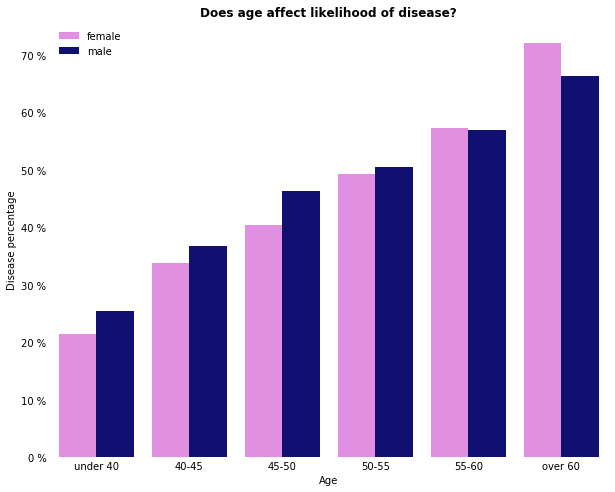

In [111]:
min_age, max_age = cardio_data['age'].min(), cardio_data['age'].max()
cardio_data['age_category'] = pd.cut(cardio_data['age'], bins = [min_age,40,45,50,55,60,max_age], labels = ['under 40', '40-45', '45-50', '50-55', '55-60', 'over 60'])
cardio_data['gender'] = cardio_data['gender'].map(lambda x: 'male' if x == 1 else 'female')
gender_age_grouped = pd.DataFrame(cardio_data.groupby(['gender', 'age_category'])['disease'].mean().round(3)).reset_index()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.catplot(x = 'age_category', y='disease', hue = 'gender', data = gender_age_grouped, kind = 'bar', palette = ['violet', 'navy'], ax = ax)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticklabels(['{} %'.format(x) for x in range(0,80,10)])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Does age affect likelihood of disease?', fontweight = 'bold')
ax.set_xlabel('Age')
ax.set_ylabel('Disease percentage')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.legend(frameon=False)
plt.close(2);

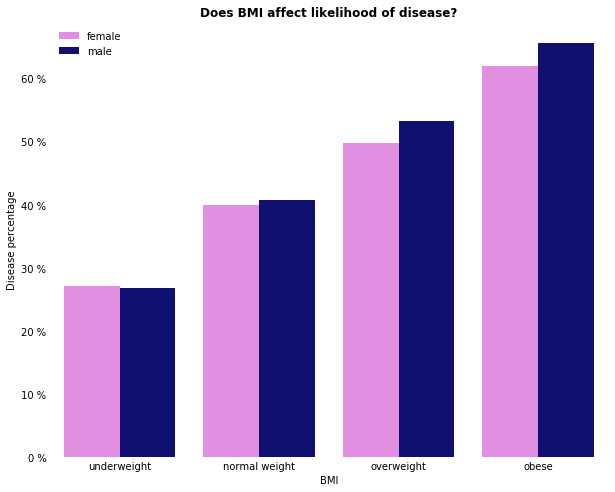

In [110]:
min_bmi, max_bmi = cardio_data['bmi'].min(), cardio_data['bmi'].max()
cardio_data['bmi_zone'] = pd.cut(cardio_data['bmi'], bins = [min_bmi,17.5,25,30,max_bmi], labels = ['underweight', 'normal weight', 'overweight', 'obese'])
gender_bmi_grouped = pd.DataFrame(cardio_data.groupby(['gender', 'bmi_zone'])['disease'].mean().round(3)).reset_index()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.catplot(x = 'bmi_zone', y='disease', hue = 'gender', data = gender_bmi_grouped, kind = 'bar', palette = ['violet', 'navy'], ax = ax)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticklabels(['{} %'.format(x) for x in range(0,80,10)])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Does BMI affect likelihood of disease?', fontweight = 'bold')
ax.set_xlabel('BMI')
ax.set_ylabel('Disease percentage')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.legend(frameon=False)
plt.close(2);

In [133]:
min_diastolic_bp, max_diastolic_bp = cardio_data['blood_pressure_min'].min(), cardio_data['blood_pressure_min'].max()
cardio_data['diastolic_zone'] = pd.cut(cardio_data['blood_pressure_min'], bins = [min_diastolic_bp,80,90,120,max_diastolic_bp], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])
cardio_data.groupby('diastolic_zone')['disease'].mean().round(3)

diastolic_zone
normal     0.390
stage 1    0.745
stage 2    0.837
stage 3    0.875
Name: disease, dtype: float64

In [134]:
min_systolic_bp, max_systolic_bp = cardio_data['blood_pressure_max'].min(), cardio_data['blood_pressure_max'].max()
cardio_data['systolic_zone'] = pd.cut(cardio_data['blood_pressure_max'], bins = [min_systolic_bp,120,140,180,max_systolic_bp], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])
cardio_data.groupby('systolic_zone')['disease'].mean().round(3)

systolic_zone
normal     0.322
stage 1    0.702
stage 2    0.861
stage 3    0.843
Name: disease, dtype: float64

In [106]:
sub_groups = [('female', 0.498), ('male', 0.505), ('non alcohol drinker', 0.501), ('alcohol drinker', 0.481), ('non active', 0.538), ('active', 0.491), ('normal cholesterol', 0.441), ('high cholesterol', 0.601), ('very high cholesterol', 0.766), ('normal glucose', 0.481), ('high glucose', 0.592), ('very high glucose', 0.622), ('under 40 years', 0.229), ('40-50 years', 0.393), ('50-60 years', 0.534), ('over 60 years', 0.7), ('underweight', 0.271), ('normal weight', 0.402), ('overweight', 0.511), ('obese', 0.629), ('normal dialostic blood pressure', 0.390), ('high dialostic blood pressure (stage 1)', 0.745), ('high dialostic blood pressure (stage 2)', 0.837), ('high dialostic blood pressure (stage 3)', 0.875), ('normal systolic blood pressure', 0.322), ('high systolic blood pressure (stage 1)', 0.702), ('high systolic blood pressure (stage 2)', 0.861), ('high systolic blood pressure (stage 3)', 0.843)]
pd.DataFrame(sub_groups, columns = ['Group', 'Disease proportion']).sort_values(by = 'Disease proportion', ascending = False).reset_index().drop(columns = ['index']).head(12)

,Group,Disease proportion
0,high dialostic blood pressure (stage 3),0.875
1,high systolic blood pressure (stage 2),0.861
2,high systolic blood pressure (stage 3),0.843
3,high dialostic blood pressure (stage 2),0.837
4,very high cholesterol,0.766
5,high dialostic blood pressure (stage 1),0.745
6,high systolic blood pressure (stage 1),0.702
7,over 60 years,0.700
8,obese,0.629
9,very high glucose,0.622


In [23]:
cardio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67618 entries, 1 to 57891
Data columns (total 12 columns):
age                    67618 non-null int64
gender                 67618 non-null int64
blood_pressure_max     67618 non-null int64
blood_pressure_min     67618 non-null int64
cholesterol_level      67618 non-null int64
glucose_level          67618 non-null int64
smoking_status         67618 non-null int64
alcohol_status         67618 non-null int64
activity_level         67618 non-null int64
disease                67618 non-null int64
bmi                    67618 non-null float64
blood_pressure_diff    67618 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.7 MB


In [24]:
from sklearn.preprocessing import StandardScaler

def pre_processing_pipeline(df, multi_class_columns, numerical_columns):
    for column in multi_class_columns:
        df[column] = df[column].astype('category')
    df_with_dummies = pd.get_dummies(df, drop_first = True)

    numerical_df = df_with_dummies[numerical_columns]
    categorical_df = df_with_dummies.drop(columns = numerical_columns)

    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns = numerical_df.columns)

    processed_df = pd.merge(scaled_df, categorical_df, left_index = True, right_index = True)
    return processed_df

In [32]:
from sklearn.model_selection import train_test_split

X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

multi_class_columns = ['cholesterol_level', 'glucose_level']
numerical_columns = ['age', 'bmi', 'blood_pressure_max', 'blood_pressure_min', 'blood_pressure_diff']
X_train = pre_processing_pipeline(X_train, multi_class_columns, numerical_columns)
X_test = pre_processing_pipeline(X_test, multi_class_columns, numerical_columns)

X_train.to_csv('cardio_train_predictors.csv')
X_test.to_csv('cardio_test_predictors.csv')
y_train.to_csv('cardio_train_target.csv')
y_test.to_csv('cardio_test_target.csv')